Chris Richardson <br><br>

Oct 10, 2022 <br><br>

ADS-509-Fall <br><br>

Github Link: [https://github.com/CFRichardson/USD_ADS_509_HW5](https://github.com/CFRichardson/ADS_509_HW5)

# Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import spacy

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel,LdaMulticore, Phrases
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

from collections import Counter, defaultdict
from nltk.corpus import brown
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from tqdm.auto import tqdm

nlp = spacy.load('en_core_web_sm')

In [2]:
# add any additional libaries you need here
from IPython.display import display


from sklearn.decomposition import TruncatedSVD

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
# warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)


In [3]:
def display_topics(model, features, no_top_words=5):
    '''
        Albrecht, Jens
        March 30, 2021
        Chapter 8: Unsupervised Methods: Topic Modeling and Clustering
        Code Version: Git commit fc9615d8c897d4fff37412e2f51330d5cc10614b
        Display Topics
        github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch08/Topic_Modeling_Clustering.ipynb
    '''
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

def Topic_Assign_Bar_Plotter(tad):
    '''
    ---------------------------
    T opic
    A assignment
    D ataFrame

    The following is a modified reference from StackID "ayhan"
    Link: https://stackoverflow.com/questions/52566616/transposing-selected-multiindex-levels-in-pandas-dataframe
     '''
    stacked_df = tad.stack().unstack(level=1)
    ''' --------------------------------- '''
    new_rows = []
    for idx, row in stacked_df.iterrows():
        # np.nansum == sum() that skips NaN values
        new_row = row / np.nansum(row)
        new_rows.append(new_row)

    new_df = pd.DataFrame(new_rows).droplevel(1)
    '''
        The following DISPLAY OF % VALUES ON CHART IS A MODIFIED COPY FROM StackOverFlow

        User: Code Different
        Link: https://stackoverflow.com/questions/68107010/show-values-in-stacked-bar-chart-pandas
    '''
    ax = new_df.plot.bar(figsize=(15,10), stacked=True);

    labels = [f'{i:.0%}' for i in new_df.to_numpy().flatten(order='F')]

    for i, patch in enumerate(ax.patches):
        x, y = patch.get_xy()
        x += patch.get_width() / 2
        y += patch.get_height() / 2
        ax.annotate(labels[i], (x, y), ha='center', va='center', c='white')

    ax.legend(bbox_to_anchor=(1, 1))


def the_contributer_counter(w_matrix, corpus_df):
    '''
        Assigns topic to each document in W_matrix.

    :param w_matrix: W_matrix from topic model.
    :return: DataFrame with assigned topic per document.
    '''

    topic_columns = ['Topic0','Topic1','Topic2','Topic3','Topic4']
    w_matrix_df = pd.DataFrame(w_matrix, columns=topic_columns)

    # initialize empty columns 2 fill
    w_matrix_df['id'] = np.nan
    w_matrix_df['category'] = np.nan
    w_matrix_df['topic'] = np.nan

    for idx, row in w_matrix_df.iterrows():
        topic_idx = np.argmax(row[topic_columns])
        w_matrix_df.loc[idx,'id'] = corpus_df.loc[idx,'id']
        w_matrix_df.loc[idx,'category'] = corpus_df.loc[idx,'category']
        w_matrix_df.loc[idx,'topic'] = row.index[topic_idx]

    return w_matrix_df


def topic_cat_counter(w_matrix_df):
    topic_cat_count_df = w_matrix_df.groupby(['topic','category'])['Topic0'].count().to_frame()
    topic_cat_count_df = topic_cat_count_df.rename(columns={'Topic0':'Count'})

    sorted_dfs = []
    for topic, df in topic_cat_count_df.groupby(level=0):
        sorted_dfs.append(df.sort_values(by='Count', ascending=False))
    return pd.concat(sorted_dfs)

# Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [4]:
# categories of articles in Brown corpus from LIBRARY NLTK
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [5]:
categories = ['editorial', 'government', 'hobbies', 'news', 'romance']

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [6]:
# length of text
df['char_len'] = df['text'].apply(len)
# count of tokens
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

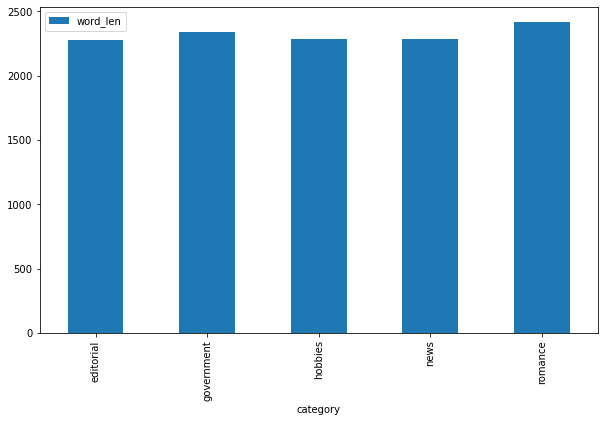

In [7]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6));

# TF-IDF & Count Vectorizations
Now do our TF-IDF and Count vectorizations.

In [8]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

(166, 4941)

In [9]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

#### Q&A
Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold?

A:
`count_text_vectors` contains our document term matrix, as shown on page 126 and 131 of BTAP.  While `tfidf_text_vectors` contains our Term Frequency Inverse Document Frequency vectors, which is the calculation of the Inverse Document Frequency times Term Frequency (which could be built by utilizing count_text_vectors) as shown on page 136 of BTAP.

# Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [10]:
nmf_text_model = NMF(n_components=5, random_state=314);
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors);
H_text_matrix = nmf_text_model.components_;

## Diplaying NMF Topics

In [11]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names());


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


## NMF Topic to Brown Corpus Comparison

Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results.


## Document Topic Assignment
First step is to convert both our W and H matrices into Pandas DataFrames for certain things like row index preservation to compare the matrices to the orignal dataframe corpus.

In [12]:
nmf_w_matrix_df = the_contributer_counter(W_text_matrix, df)
nmf_w_matrix_df.head(2)

,Topic0,Topic1,Topic2,Topic3,Topic4,id,category,topic
0,0.168324,0.0,0.196772,0.0,0.02855,cb01,editorial,Topic2
1,0.321743,0.0,0.000000,0.0,0.00000,cb02,editorial,Topic0


In [13]:
nmf_tcc = topic_cat_counter(nmf_w_matrix_df)
nmf_tcc

Count
topic  category         
Topic0 editorial      20
       news            8
       government      4
Topic1 romance        29
       hobbies         8
       editorial       4
Topic2 government     26
       hobbies        26
       news           11
       editorial       2
Topic3 news           17
       hobbies         1
Topic4 news            8
       editorial       1
       hobbies         1

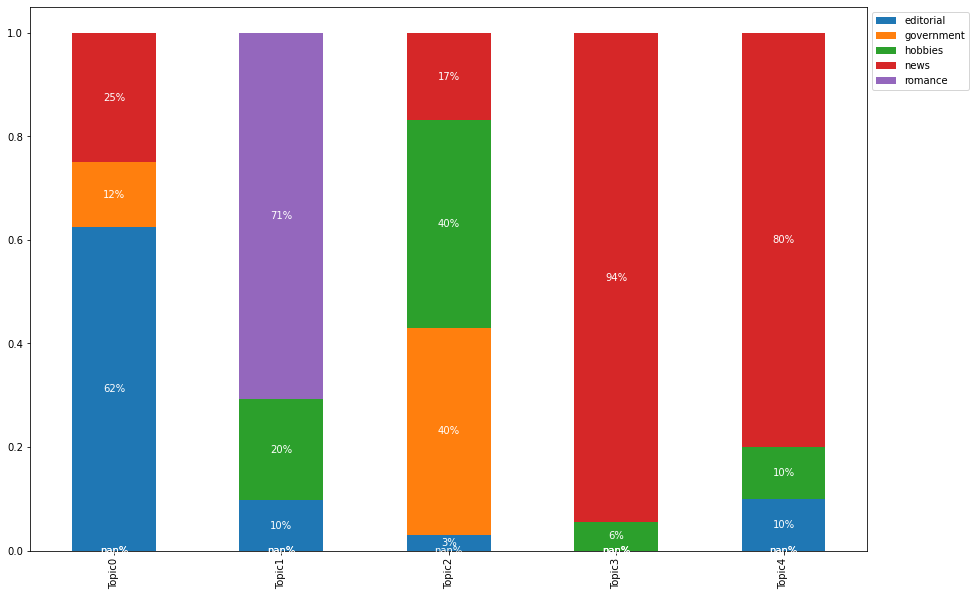

In [14]:
Topic_Assign_Bar_Plotter(nmf_tcc)

#### Q&A
Q: How does your five-topic NMF model compare to the original Brown categories?

A:Topic00 has the word probabilities that are slowly decreasing.  Thus it is a less-pronounced topic that is mainly comprised of Editorial documents.  Having the words (1) mr, (2) president, (3) kennedy, and (5) khruschev, I would assume this topic is mainly comprised of "government" and "news" documents.  It is possible that the particular editorial pieces are about governments and thus may be misleading by the idea that some "editorial" pieces would be better off being labeled as a new category termed "government editorials".

Topic01 is mainly compromised of Stop Words, consisting majority of documents from Romance though I would have never suspected it by looking at the topic words.

Just about 80% ((26/65)*2) of Topic02 information is split between "government" and "hobbies" with "news" contributing 16.92% (26/65).  By simply looking at Topic02, I am only able to tell that the topic is related to news documents and nothing more.

Topic 03 visually looks like a romance-related topic, but news makes up 94.44% of the related documents (17 out of 18) with 5.66% or one document being that of the hobby category.

Topic 04 appears to be purely sports news, and apparently, eight out of the ten documents comprising Topic 0-4 is news, while 1 document is that of hobbies and another of editorial.  Which to me, Topic 04 is the most coherent and straight forward topic and the tallies of categories truly tells this.


# Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above.

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results.


In [15]:
svd_para_model = TruncatedSVD(n_components = 5, random_state=42)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_text_vectors)
H_svd_para_matrix = svd_para_model.components_

In [56]:
svd_w_matrix_df = the_contributer_counter(W_svd_para_matrix, df)
svd_w_matrix_df.head(2)

,Topic0,Topic1,Topic2,Topic3,Topic4,id,category,topic
0,0.389572,-0.249656,-0.023332,-0.055891,-0.003281,cb01,editorial,Topic0
1,0.363091,-0.237287,0.209713,-0.259419,0.154332,cb02,editorial,Topic0


## Document Topic Assignment

In [43]:
svd_tcc = topic_cat_counter(svd_w_matrix_df)
svd_tcc

Count
topic  category         
Topic0 hobbies        36
       news           34
       government     30
       editorial      27
       romance        21
Topic1 romance         8
Topic3 news            3
Topic4 news            7

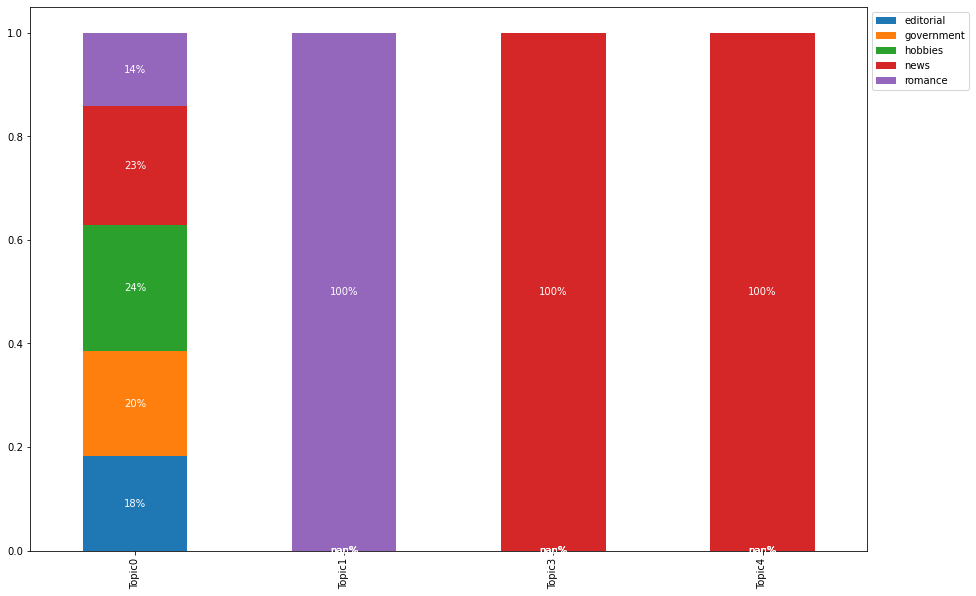

In [18]:
Topic_Assign_Bar_Plotter(svd_tcc)

In [ ]:
'''
    A sneak peek into why there is no Topic02 in the above chart
'''
# topic_columns = ['Topic0','Topic1','Topic2','Topic3','Topic4']
# svd_w_matrix_df = pd.DataFrame(W_svd_para_matrix, columns=topic_columns)
#
# # initialize empty columns 2 fill
# svd_w_matrix_df['id'] = np.nan
# svd_w_matrix_df['category'] = np.nan
# svd_w_matrix_df['topic'] = np.nan
#
# for idx, row in svd_w_matrix_df.iterrows():
#     topic_idx = np.argmax(row[topic_columns])
#     svd_w_matrix_df.loc[idx,'id'] = df.loc[idx,'id']
#     svd_w_matrix_df.loc[idx,'category'] = df.loc[idx,'category']
#     svd_w_matrix_df.loc[idx,'topic'] = row.index[topic_idx]
# svd_w_matrix_df['topic'].value_counts()

#### Q&A

Q: How does your five-topic LSA model compare to the original Brown categories?

A: I am surprised, no wonder why we are to compare the model to the Brown categories before looking at display topics.  It appears that Topic0 encompasses a little bit of everything from the corpus.  While the other topics are  single category.  For example, Topic3 has a `news` count of 3.  Surprisingly enough, no documents were assigned to Topic02.

In [19]:
display_topics(svd_para_model, tfidf_text_vectorizer.get_feature_names());


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.07)
  mr (1.74)
  said (1.06)
  kennedy (0.85)
  khrushchev (0.82)

Topic 03
  mrs (28.72)
  club (6.51)
  game (5.71)
  jr (5.45)
  dallas (5.19)

Topic 04
  game (4.77)
  league (3.40)
  baseball (3.38)
  ball (3.26)
  team (3.09)


#### Q&A
Q: What is your interpretation of the display topics output?

A:  Looking at Topic00, I assume it would be related to a mixture of categories, especially government and news.  Topic01 is still unrecognizable to me.  Topic02 appears to be news or government, nearly the same as NMF's Topic03, with a slightly different word makeup and categorical makeup.  Topic03 seems related to hobbies, though the categorical makeup is purely news.  Topic04 is nearly identical to NMF Topic04 with the exact word makeup though different weights.  Surprisingly SVD Topic04 has a separate category makeup in comparison to NMF Topic04.


In [60]:
def topic_displayer(tcc, topic='Topic4'):
    for idx_df, topic_idx_df in tcc.groupby(level=0):
        if idx_df == 'Topic4':
            display(topic_idx_df)

In [61]:
topic_displayer(svd_tcc)

,,Count
topic,category,
Topic4,news,7


In [62]:
topic_displayer(nmf_tcc)

Count
topic  category        
Topic4 news           8
       editorial      1
       hobbies        1

# Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [20]:
lda_para_model = LatentDirichletAllocation(n_components = 5, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_text_vectors)
H_lda_para_matrix = lda_para_model.components_

## Displaying LDA Topics

In [21]:
display_topics(lda_para_model, tfidf_text_vectorizer.get_feature_names());


Topic 00
  mrs (0.78)
  home (0.48)
  right (0.35)
  game (0.33)
  set (0.33)

Topic 01
  state (0.88)
  development (0.57)
  program (0.46)
  use (0.44)
  states (0.36)

Topic 02
  said (0.94)
  mr (0.73)
  president (0.64)
  state (0.50)
  000 (0.38)

Topic 03
  united (0.95)
  states (0.89)
  shall (0.86)
  government (0.86)
  feed (0.85)

Topic 04
  said (1.58)
  little (0.63)
  man (0.63)
  old (0.59)
  good (0.54)


#### Q&A

Q: What inference do you draw from the displayed topics for your LDA model?

A:  Topics for LDA appear to be slightly better than the other models due to the fact that I am confident in my topic, categorical makeup assumptions.  But after reviewing the following charts, I stand corrected.  But then again, I am not so confident in my Document Topic Assignment calculations.

With Topic01 appearing to be a mixture of hobbies and romance, Topic01 appearing to be a mixture of government and news, Topic02 a mix of news and government, Topic03 being purely government though the weights are barely degrading, and Topic04 reminds me of a comedy and thus I would assume it is hobby related (LDA tcc shows Topic04 is prodominantly romance)


## Document Topic Assignment
#### Q:
Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories?

In [22]:
lda_w_matrix_df = the_contributer_counter(W_lda_para_matrix, df)
lda_tcc = topic_cat_counter(lda_w_matrix_df)
lda_tcc

Count
topic  category         
Topic0 hobbies        14
       news           12
       editorial       2
       romance         1
Topic1 government     17
       hobbies        17
       news            3
       editorial       2
Topic2 news           27
       editorial      22
       government      2
       hobbies         1
Topic3 government     11
       news            2
       hobbies         1
Topic4 romance        28
       hobbies         3
       editorial       1

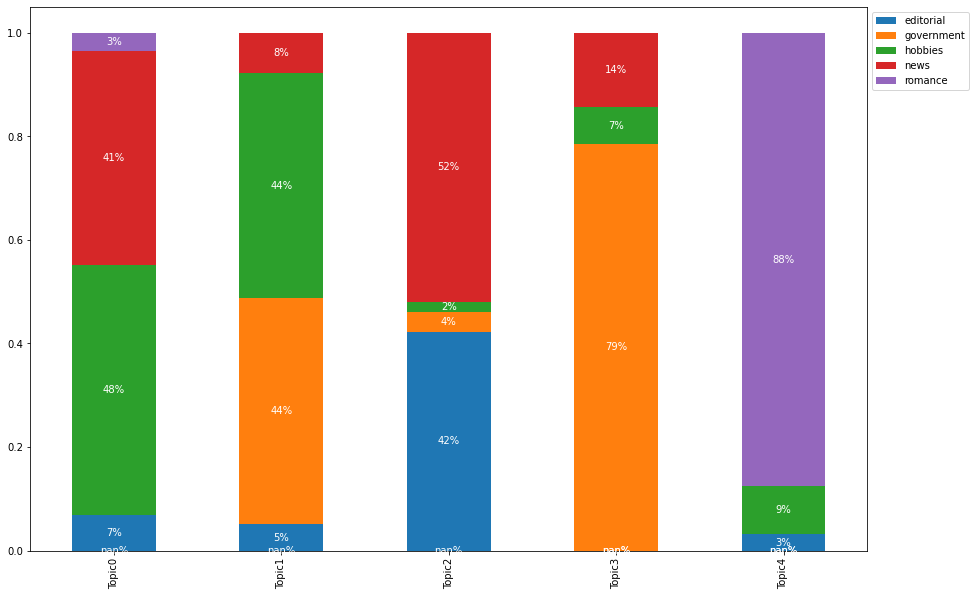

In [23]:
Topic_Assign_Bar_Plotter(lda_tcc)

#### Answer to Question

A:  Looking at LDA_tcc shows that each topic has three to four categories, with one to two strong categories creating the Topic document makeup.  In example, Topic0 is mainly comprised of editorial documents (62.5% = 20 editorial / 32 total documents).  It appears that LDA is able to extract the relevance of words from a document, which results to the various documents creating each of the topics.  This is shown in Topic04, where the main category is romance with 28 documents, 3 hobby documents, and 1 editorial.  The 3 hobby documents and 1 editorial could easily be romance related documents and LDA picked that up.


## LDA GUI

In [66]:
lda_display = pyLDAvis.sklearn.prepare(lda_para_model, count_text_vectors, count_text_vectorizer, sort_topics=False);

In [70]:
pyLDAvis.display(lda_display)


#### Q&A
Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: *Due to Python's number system starting at 0, thus topic numbers displayed on the PCA plot is the displayed topic number minus one.


Interestingly, topics 1 and 2 (visually plotted as 2 and 3) overlap on the PCA plot, where topic 3 appears to be comprised of government documents, and topic 2 occurs to be composed of news articles.  The other three topics are clearly separated and are in different quadrants of the cartesian plane.  Thus topics 2, 3, and 4 are very similar.  While topics 1 and 5 are clearly either romance or hobby-based topics.
